In [158]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import albumentations as A
from functools import partial
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()


In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [20]:
train_images = train_images / 255.0

test_images = test_images / 255.0


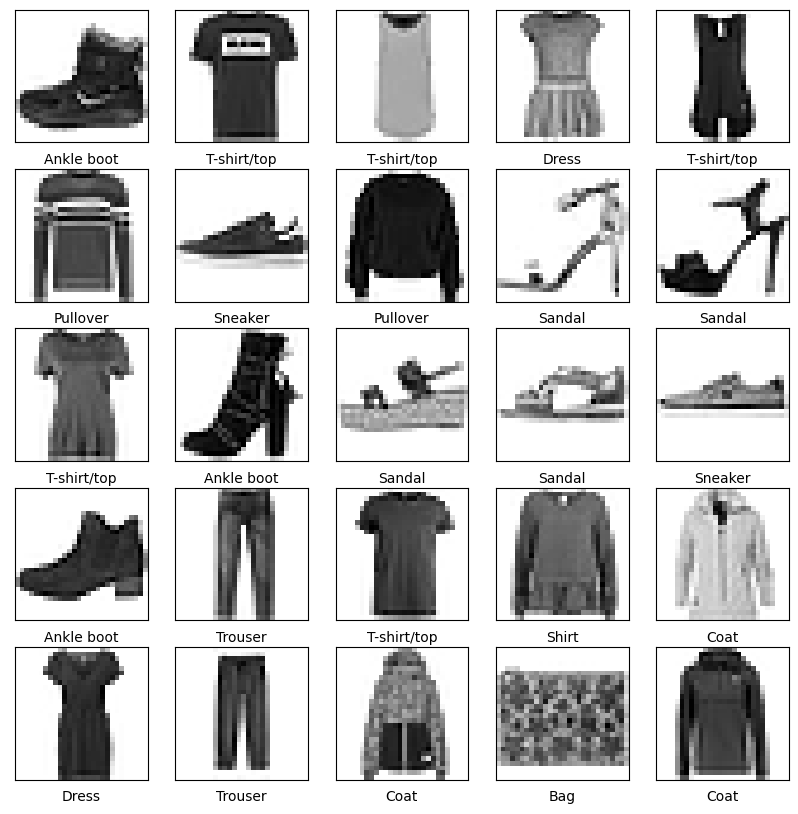

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [107]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_images, train_labels, test_size=0.1, random_state=10, stratify=train_labels)

In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [109]:
def exponential_decay_fn(epoch, current_lr):
  return current_lr * 0.2**(epoch / 10)

In [110]:
adam_optim = tf.keras.optimizers.Adam(learning_rate=0.001, decay=exponential_decay_fn(30, 0.001))

In [111]:
model.compile(optimizer=adam_optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [112]:
EPOCHS = 30
checkpoint_filepath = './tmp2/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [113]:
train_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=128, callbacks=[model_checkpoint_callback])

#!mkdir -p saved_model
#model.save('saved_model/my_model')


Epoch 1/30
338/338 [==============================] - 4s 9ms/step - loss: 0.5416 - accuracy: 0.8089 - val_loss: 0.3986 - val_accuracy: 0.8572
Epoch 2/30
338/338 [==============================] - 3s 8ms/step - loss: 0.3912 - accuracy: 0.8590 - val_loss: 0.3359 - val_accuracy: 0.8817
Epoch 3/30
338/338 [==============================] - 2s 7ms/step - loss: 0.3441 - accuracy: 0.8746 - val_loss: 0.3352 - val_accuracy: 0.8744
Epoch 4/30
338/338 [==============================] - 3s 9ms/step - loss: 0.3171 - accuracy: 0.8824 - val_loss: 0.3215 - val_accuracy: 0.8841
Epoch 5/30
338/338 [==============================] - 3s 8ms/step - loss: 0.2975 - accuracy: 0.8888 - val_loss: 0.3223 - val_accuracy: 0.8844
Epoch 6/30
338/338 [==============================] - 2s 7ms/step - loss: 0.2817 - accuracy: 0.8952 - val_loss: 0.3422 - val_accuracy: 0.8771
Epoch 7/30
338/338 [==============================] - 3s 8ms/step - loss: 0.2660 - accuracy: 0.9000 - val_loss: 0.2977 - val_accuracy: 0.8919
Epoch 

In [114]:
os.listdir(checkpoint_filepath)

['.data-00000-of-00001', '.index', 'checkpoint']

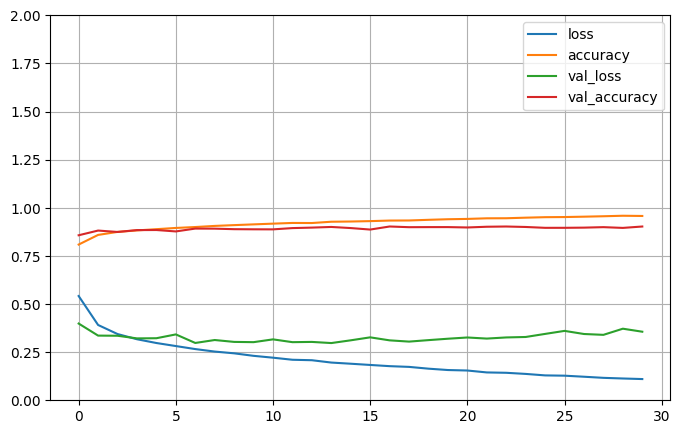

In [115]:
pd.DataFrame(train_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [118]:
model.load_weights(checkpoint_filepath)

In [119]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

188/188 - 1s - loss: 0.3275 - accuracy: 0.8942 - 500ms/epoch - 3ms/step

Test accuracy: 0.8941666483879089


In [120]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


In [121]:
def weryfikacja(nr):
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(nr, predictions[nr], y_test, X_test)
    plt.subplot(1,2,2)
    plot_value_array(nr, predictions[nr],  y_test)
    plt.show()


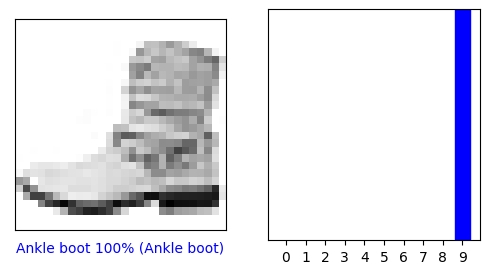

In [122]:
weryfikacja(3)

# Rozwiązanie z augmentacją

In [161]:
data, info= tfds.load(name="fashion_mnist", split="train", as_supervised=True, with_info=True)
data


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\lukpy\tensorflow_datasets\fashion_mnist\3.0.1.incomplete5DNXNO\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\lukpy\tensorflow_datasets\fashion_mnist\3.0.1.incomplete5DNXNO\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\lukpy\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [162]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [163]:
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

D:\Kodilla\kurs_pythona\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
D:\Kodilla\kurs_pythona\lib\site-packages\albumentations\augmentations\transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
D:\Kodilla\kurs_pythona\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [246]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [247]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [255]:
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [256]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label


In [257]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [259]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [260]:
model2.compile(optimizer=adam_optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [261]:
model2.fit(ds_alb, epochs=2)


Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "D:\Kodilla\kurs_pythona\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Kodilla\kurs_pythona\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Kodilla\kurs_pythona\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "D:\Kodilla\kurs_pythona\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\Kodilla\kurs_pythona\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "D:\Kodilla\kurs_pythona\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "D:\Kodilla\kurs_pythona\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "D:\Kodilla\kurs_pythona\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Kodilla\kurs_pythona\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\lukpy\AppData\Local\Temp\ipykernel_16416\2290107530.py", line 1, in <module>
      model2.fit(ds_alb, epochs=2)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "D:\Kodilla\kurs_pythona\lib\site-packages\keras\engine\training.py", line 1009, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Incompatible shapes at component 0: expected [?,120,120,3] but got [32,120,120,1].
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_625878]